# <center> DataLab Cup 4 : Unlearnable Dataset </center>
## <center>Neural Tangent Generalization Attacks (NTGA)</center>

In [4]:
!pip install tensorflow-addons

### import Library

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras
from tensorflow.keras.models import Sequential
import tensorflow_addons as tfa
import os

import string
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
import random
import time
from pathlib import Path

from tqdm import tqdm

import re
from IPython import display

BATCH_SIZE = 64

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Restrict TensorFlow to only use the first GPU
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
x_train = np.load('./dataset/x_train_cifar10_unlearn.npy')
y_train = np.load('./dataset/y_train_cifar10.npy')
x_val = np.load('./dataset/x_val_cifar10.npy')
y_val = np.load('./dataset/y_val_cifar10.npy')

y_train = np.argmax(y_train, axis=1)
y_val = np.argmax(y_val, axis=1)

In [6]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
batched_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=True)

val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
batched_val_dataset = val_dataset.batch(BATCH_SIZE, drop_remainder=True)

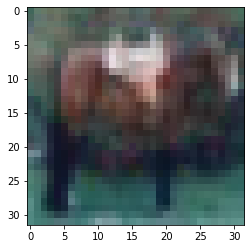

In [10]:
for data in batched_dataset.take(1):
    plt.imshow(data[0][3],cmap='gray')

### Model

In [42]:
model = Sequential([
  keras.Input(shape=(32, 32, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(10)
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 32, 32, 16)        448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 16, 16, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 16, 16, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 8, 8, 32)         0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 8, 8, 64)          18496     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 4, 4, 64)        

In [43]:
loss_fn = tf.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss=loss_fn, metrics=['acc'])

In [30]:
history = model.fit(x=batched_dataset, validation_data=batched_val_dataset, epochs=50)

Epoch 1/50
625/625 [==============================] - 7s 7ms/step - loss: 1.2790 - acc: 0.5694 - val_loss: 2.2582 - val_acc: 0.3120
Epoch 2/50
625/625 [==============================] - 4s 7ms/step - loss: 0.4627 - acc: 0.8610 - val_loss: 2.3075 - val_acc: 0.3191
Epoch 3/50
625/625 [==============================] - 4s 7ms/step - loss: 0.2917 - acc: 0.9131 - val_loss: 2.4511 - val_acc: 0.3282
Epoch 4/50
625/625 [==============================] - 4s 7ms/step - loss: 0.2096 - acc: 0.9359 - val_loss: 2.6140 - val_acc: 0.3172
Epoch 5/50
625/625 [==============================] - 4s 7ms/step - loss: 0.1581 - acc: 0.9523 - val_loss: 2.8462 - val_acc: 0.3041
Epoch 6/50
625/625 [==============================] - 5s 7ms/step - loss: 0.1231 - acc: 0.9618 - val_loss: 3.1139 - val_acc: 0.3002
Epoch 7/50
625/625 [==============================] - 5s 8ms/step - loss: 0.0954 - acc: 0.9691 - val_loss: 3.4415 - val_acc: 0.2808
Epoch 8/50
625/625 [==============================] - 4s 7ms/step - loss: 0.

### Property of NTGA

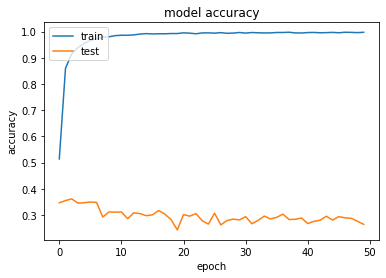

In [16]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Testing

In [56]:
x_test = np.load('./dataset/x_test_cifar10.npy')
test_dataset = tf.data.Dataset.from_tensor_slices((x_test))
batched_test_dataset = test_dataset.batch(BATCH_SIZE, drop_remainder=False)

In [57]:
print(len(x_test))
print(len(test_dataset))
print(len(batched_test_dataset))

10000
10000
157


In [58]:
result = model.predict(x=batched_test_dataset)

In [59]:
len(result)

10000

In [62]:
result.shape

(10000, 10)

In [73]:
result

array([[-0.04393432, -0.0798047 , -0.24327485, ...,  0.00127435,
        -0.14885293,  0.02855207],
       [-0.04837721, -0.04913528, -0.22698417, ...,  0.0193783 ,
        -0.16397434,  0.06568741],
       [ 0.02019629,  0.02319831, -0.17241439, ...,  0.05608439,
        -0.11866691, -0.05888293],
       ...,
       [-0.02380493, -0.01708651, -0.3738721 , ...,  0.01836943,
        -0.20118186,  0.08057974],
       [-0.0203372 , -0.02627284, -0.24384463, ...,  0.01238948,
        -0.15801382,  0.05590353],
       [-0.0048778 , -0.02825364, -0.22971855, ...,  0.00985257,
        -0.18000358,  0.05708458]], dtype=float32)

In [77]:
final_result = np.argmax(result, axis=1)
final_result

array([3, 9, 3, ..., 9, 3, 3], dtype=int64)

In [78]:
output = pd.DataFrame({'id':range(len(final_result)), 'label':final_result})
output.to_csv('./output/output.csv', header=True, index=False)